https://medium.com/analytics-vidhya/our-experience-with-numerai-2b0777acc12e

Previous year's similar project. Our goal is to validate their results and processes for a selection of models, namely the linear regressor, xgboost and catboost model as well as a stacked ensemble of our best tuned models. The extension is comparing this to emerging WGAN-GP model and hopefully showing a higher performing trading strategy using this model.

Task Lists:

data processing

linear simple model

xgb model (tuning and everything)

cat model (tuning and everything)

stacked model

Era Boosting: where we are essentially boosting the weights of the lower eras to increase correlation, decrease standard deviation, and thus increase the sharpe score and performance.

gans model

util function for sharpe score

feature reengineering and statistical/correlation/fisher scoring analysis

util function for turning predictions into stock bets and calulating returns/losses

Model loading function


POST:

Reports

supporting literature

presentation slides

recorded presentation

In [ ]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math

        Date      Open      High       Low     Close      Volume      NASDAQ   \
0 2010-07-01  9.082143  9.100000  8.686429  8.874286  1022896000  2101.360107   
1 2010-07-02  8.946072  8.961785  8.685715  8.819285   693842800  2091.790039   
2 2010-07-06  8.964286  9.028571  8.791429  8.879642   615235600  2093.879883   
3 2010-07-07  8.946072  9.241786  8.919642  9.238214   654556000  2159.469971   
4 2010-07-08  9.374286  9.389286  9.103214  9.217500   738144400  2175.399902   

         NYSE       S&P 500  FTSE100  ...  RUSSELL2000    HENG SENG  \
0  6462.029785  1027.369995  4805.75  ...   604.760010          NaN   
1  6434.810059  1022.580017  4838.09  ...   598.969971  19905.32031   
2  6486.089844  1028.060059  4965.00  ...   590.030029  20084.11914   
3  6685.779785  1060.270020  5014.82  ...   611.659973  19857.07031   
4  6755.810059  1070.250000  5105.45  ...   620.270020  20050.56055   

           SSE  Crude Oil         Gold        VIX  USD index      Amazon  \
0  2373.79

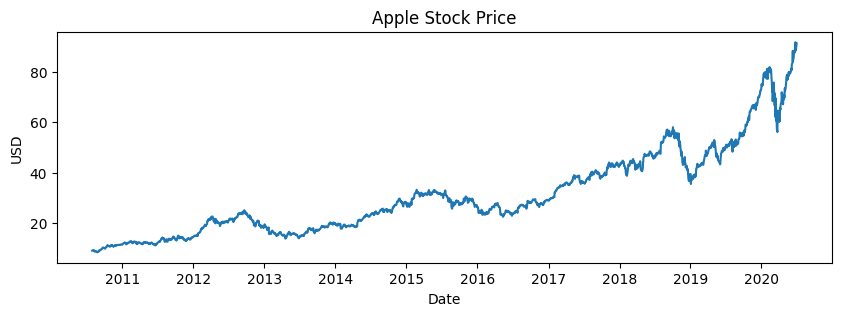

        Date      Open      High       Low     Close     Volume      NASDAQ   \
0 2010-07-30  9.138928  9.275000  9.103572  9.187500  448210000  2254.699951   
1 2010-08-02  9.301429  9.378214  9.272142  9.351786  428055600  2295.360107   
2 2010-08-03  9.321786  9.402143  9.265000  9.354643  417653600  2283.520020   
3 2010-08-04  9.387143  9.438571  9.296785  9.392143  420375200  2303.570068   
4 2010-08-05  9.347500  9.399285  9.305357  9.346429  289097200  2293.060059   

         NYSE       S&P 500  FTSE100  ...  upper_band  lower_band       EMA  \
0  6998.990234  1101.599976  5258.02  ...    9.471127    8.739587  9.211011   
1  7174.899902  1125.859985  5397.11  ...    9.479903    8.776288  9.304861   
2  7146.990234  1120.459961  5396.48  ...    9.494345    8.812832  9.338049   
3  7182.140137  1127.239990  5386.16  ...    9.532183    8.823803  9.374112   
4  7174.270020  1125.810059  5365.78  ...    9.545201    8.821092  9.355657   

   logmomentum  absolute of 3 comp  angle of

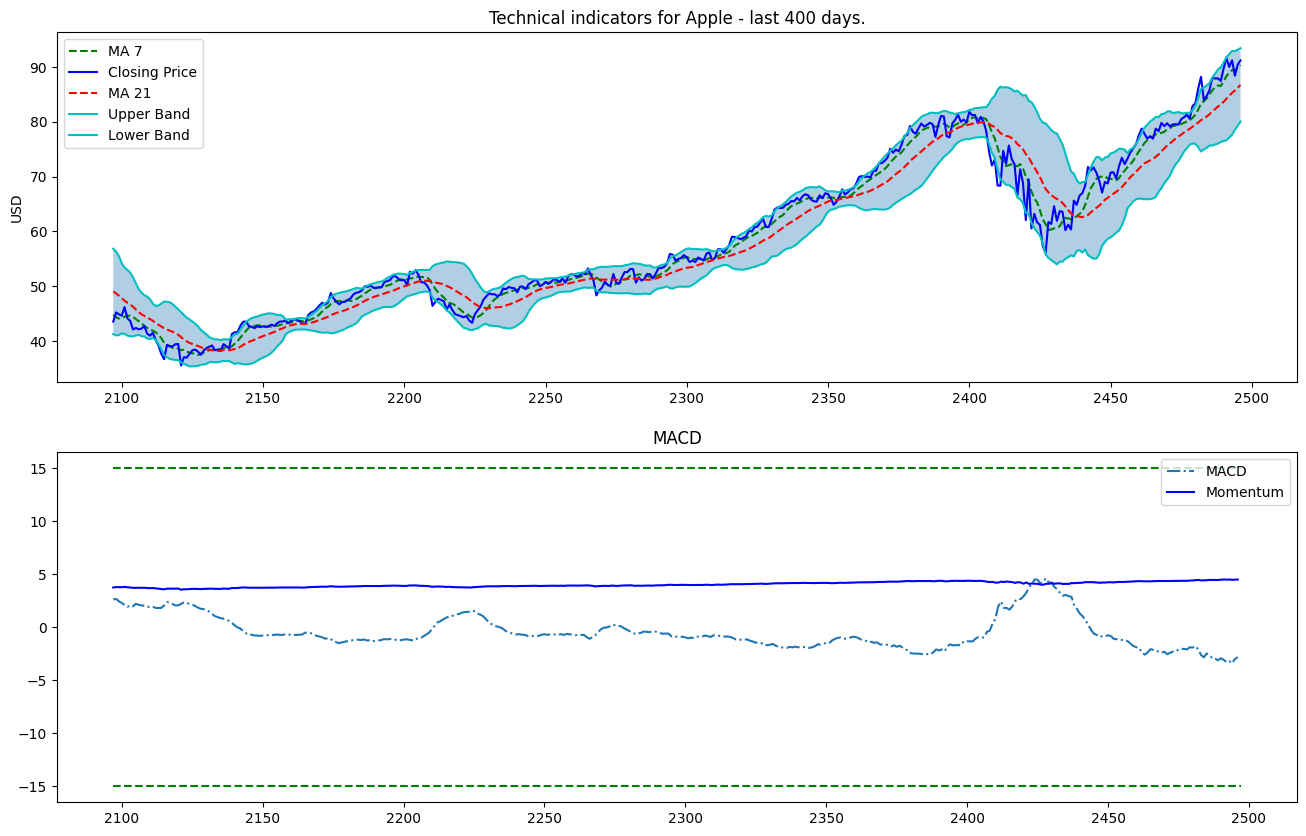

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


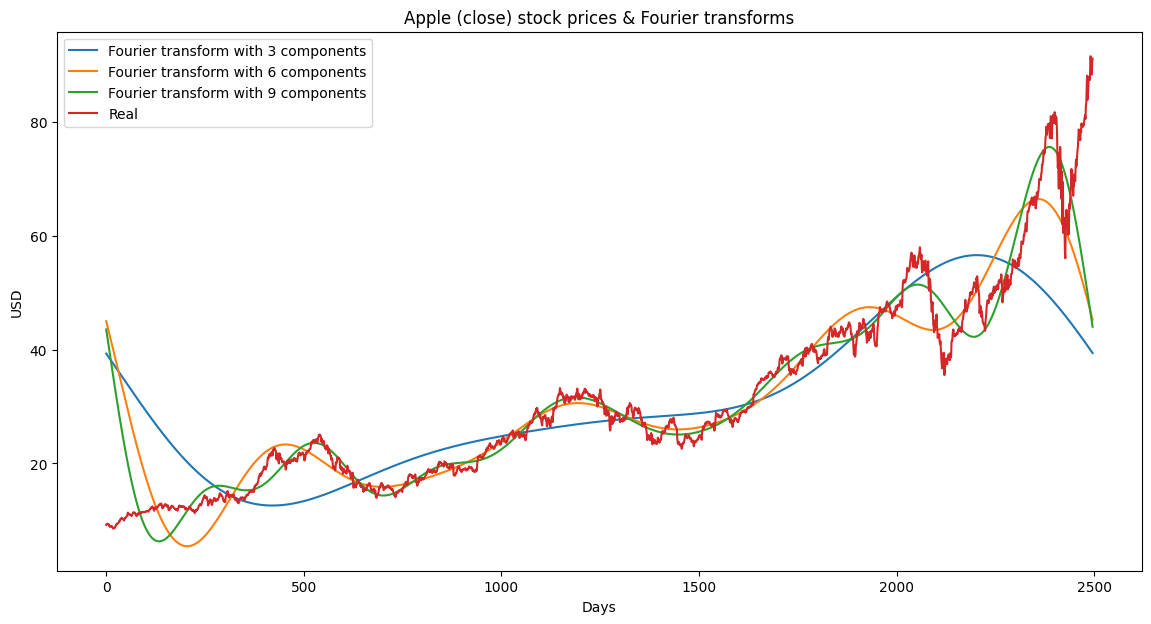

In [ ]:


## import data
df = pd.read_csv('DATA.csv', parse_dates=['Date'])
print(df.head())
print(df.tail())
print(df.shape)
print(df.columns)

# Calculate technical indicators
def get_technical_indicators(data):
    # Create 7 and 21 days Moving Average
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA21'] = data.iloc[:,4].rolling(window=21).mean()

    # Create MACD
    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA21'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA21'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data
T_df = get_technical_indicators(df)

#Drop the first 21 rows
#For doing the fourier
dataset = T_df.iloc[20:,:].reset_index(drop=True)

#Getting the Fourier transform features
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

#Get Fourier features
dataset_F = get_fourier_transfer(dataset)
Final_data = pd.concat([dataset, dataset_F], axis=1)

"""
for column in Final_data.columns[1:]:
  print(column)
  data = Final_data[column]

  percent_data = np.zeros(shape=(len(data), 1)).flatten()
  percent_data[0] = 1.0

  for index, price in enumerate(data[1:]):
    percent_data[index + 1] = (data[index + 1] / data[index])

  Final_data[column] = percent_data
"""

# Create Apple stock price plot
## https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
fig, ax = plt.subplots(figsize=(10,3))
ax.plot(Final_data['Date'], Final_data['Close'], label='Apple stock')
ax.set(xlabel="Date",
       ylabel="USD",
       title="Apple Stock Price")
date_form = DateFormatter("%Y")
ax.xaxis.set_major_formatter(date_form)
plt.show()


print(Final_data.head())


Final_data.to_csv("Finaldata_with_Fourier.csv", index=False)

def plot_technical_indicators(dataset, last_days):
       plt.figure(figsize=(16, 10), dpi=100)
       shape_0 = dataset.shape[0]
       xmacd_ = shape_0 - last_days

       dataset = dataset.iloc[-last_days:, :]
       x_ = range(3, dataset.shape[0])
       x_ = list(dataset.index)

       # Plot first subplot
       plt.subplot(2, 1, 1)
       plt.plot(dataset['MA7'], label='MA 7', color='g', linestyle='--')
       plt.plot(dataset['Close'], label='Closing Price', color='b')
       plt.plot(dataset['MA21'], label='MA 21', color='r', linestyle='--')
       plt.plot(dataset['upper_band'], label='Upper Band', color='c')
       plt.plot(dataset['lower_band'], label='Lower Band', color='c')
       plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
       plt.title('Technical indicators for Apple - last {} days.'.format(last_days))
       plt.ylabel('USD')
       plt.legend()

       # Plot second subplot
       plt.subplot(2, 1, 2)
       plt.title('MACD')
       plt.plot(dataset['MACD'], label='MACD', linestyle='-.')
       plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
       plt.plot(dataset['logmomentum'], label='Momentum', color='b', linestyle='-')

       plt.legend()
       plt.show()

plot_technical_indicators(Final_data, 400)


def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Apple (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(Final_data)

<ipython-input-4-69e104ca4632>:28: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NASDAQ ', 'NYSE ',
       'S&P 500', 'FTSE100', 'NIKKI225', 'BSE SENSEX', 'RUSSELL2000',
       'HENG SENG', 'SSE', 'Crude Oil', 'Gold', 'VIX', 'USD index', 'Amazon',
       'Google', 'Microsoft', 'MA7', 'MA21', 'MACD', '20SD', 'upper_band',
       'lower_band', 'EMA', 'logmomentum', 'absolute of 3 comp',
       'angle of 3 comp', 'absolute of 6 comp', 'angle of 6 comp',
       'absolute of 9 comp', 'angle of 9 comp'],
      dtype='object')
                 Open       High        Low      Close       Volume  \
2010-07-30   9.138928   9.275000   9.103572   9.187500  448210000.0   
2010-08-02   9.301429   9.378214   9.272142   9.351786  428055600.0   
2010-08-03   9.321786   9.402143   9.265000   9.354643  417653600.0   
2010-08-04   9.387143   9.438571   9.296785   9.392143  420375200.0   
2010-08-05   9.347500   9.399285   9.305357   9.346429  289097200.0   
...               ...        ...        ...        ...          ...   


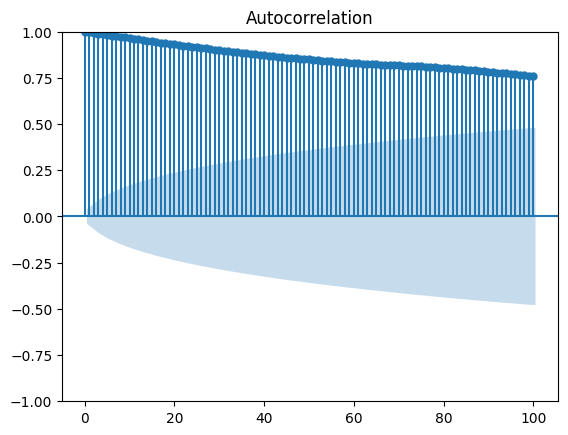

X shape:  (2494, 3, 35)
y shape:  (2494, 1)
X_train shape:  (1746, 3, 35)
y_train shape:  (1746, 1)
y_c_train shape:  (1746, 3, 1)
X_test shape:  (748, 3, 35)
y_test shape:  (748, 1)
y_c_test shape:  (748, 3, 1)
index_train shape: (1746,)
index_test shape: (748,)
[[[-0.9845919  -0.98554176 -0.983185   ... -0.70197358  0.07341986
   -0.63725877]
  [-0.98066432 -0.98309681 -0.97908128 ... -0.70409061  0.05984419
   -0.63882602]
  [-0.9801723  -0.98252998 -0.97925515 ... -0.70619369  0.04626476
   -0.64032035]]

 [[-0.98066432 -0.98309681 -0.97908128 ... -0.70409061  0.05984419
   -0.63882602]
  [-0.9801723  -0.98252998 -0.97925515 ... -0.70619369  0.04626476
   -0.64032035]
  [-0.97859265 -0.98166707 -0.97848136 ... -0.70828236  0.03268433
   -0.64173929]]

 [[-0.9801723  -0.98252998 -0.97925515 ... -0.70619369  0.04626476
   -0.64032035]
  [-0.97859265 -0.98166707 -0.97848136 ... -0.70828236  0.03268433
   -0.64173929]
  [-0.9795508  -0.98259768 -0.97827268 ... -0.71035613  0.01910564
 

In [ ]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

# %% --------------------------------------- Load Data  -----------------------------------------------------------------
dataset = pd.read_csv('Finaldata_with_Fourier.csv', parse_dates=['Date'])
#news = pd.read_csv("News.csv", parse_dates=["Date"])

# %% --------------------------------------- Data Preprocessing  -----------------------------------------------------------------

# Replace 0 by NA
dataset.replace([0, np.inf, -np.inf], np.nan, inplace=True)
dataset.to_csv("dataset.csv", index=False)
# Add News data
#dataset["News"] = news["Score"]

# Check NA and fill them
dataset.isnull().sum()
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill(), dataset.iloc[:, 1:].bfill()]).groupby(level=0).mean()
print(dataset.columns)

# Set the date to datetime data
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

# Get features and target
X_value = pd.DataFrame(dataset.iloc[:, :])
print(X_value)
y_value = pd.DataFrame(dataset.iloc[:, 3])

# Autocorrelation Check
sm.graphics.tsa.plot_acf(y_value.squeeze(), lags=100)
plt.show()

# Normalized the data
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

dump(X_scaler, open('X_scaler.pkl', 'wb'))
dump(y_scaler, open('y_scaler.pkl', 'wb'))

# Reshape the data
'''Set the data input steps and output steps,
    we use 30 days data to predict 1 day price here,
    reshape it to (None, input_step, number of features) used for LSTM input'''
n_steps_in = 3
n_features = X_value.shape[1]
n_steps_out = 1

# Get X/y dataset
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == 3 and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

# Split train/test dataset
def split_train_test(data):
    train_size = round(len(X) * 0.7)
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

# Get data and check shape
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, n_steps_in, n_steps_out)
# %% --------------------------------------- Save dataset -----------------------------------------------------------------
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)
np.save("yc_train.npy", yc_train)
np.save("yc_test.npy", yc_test)
np.save('index_train.npy', index_train)
np.save('index_test.npy', index_test)
print(X_train)

In [ ]:
# Load data
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)
yc_test = np.load("yc_test.npy", allow_pickle=True)

In [ ]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.compat.v1.keras.layers import CuDNNGRU as GRU
#from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU, Dropout
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib

# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  #recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  #recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(128,
    #              kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(Dropout(0.25))
    model.add(ReLU())
    model.add(Dense(1))
    return model

# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(5):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 1000 epochs
            if (epoch + 1) % 1000 == 0:
                tf.keras.models.save_model(generator, 'gen_GRU_model_%d.h5' % (epoch + 1))
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

Load saved model below

In [ ]:
train_mode = True
load_model = False

In [ ]:
import numpy as np
X_test = np.load("X_test.npy", allow_pickle=True)
y_test = np.load("y_test.npy", allow_pickle=True)

In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} )
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [ ]:
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.compat.v1.keras.layers import CuDNNGRU as GRU
#from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU, Dropout
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib

# Define the generator
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,
                  return_sequences=True,
                  input_shape=(input_dim, feature_size),
                  #recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,
                  #return_sequences=True,
                  #recurrent_dropout=0.02,
                  recurrent_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(128,
    #              kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(1e-3)))
    #model.add(Dense(8, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

# Define the discriminator
def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(4, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(Dropout(0.25))
    model.add(ReLU())
    model.add(Dense(1))
    return model

# Train WGAN-GP model
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        checkpoint_dir = '../training_checkpoints'
        self.checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        """ Calculates the gradient penalty.
        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # get the interpolated data
        alpha = tf.random.normal([batch_size, 4, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]

        # 3. Calcuate the norm of the gradients
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                # Train the discriminator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(5):
            with tf.GradientTape() as g_tape:
                # Train the generator
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 1000 epochs
            if (epoch + 1) % 1000 == 0:
                tf.keras.models.save_model(generator, 'gen_GRU_model_retrain_v2.0_%d.h5' % (epoch + 1))
                self.checkpoint.save(file_prefix=self.checkpoint_prefix)
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)

        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print(Real_price)
        print("PREDICTED", Predicted_price.shape)
        print(Predicted_price)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [ ]:
X_train = np.load("X_train.npy", allow_pickle=True)
y_train = np.load("y_train.npy", allow_pickle=True)
yc_train = np.load("yc_train.npy", allow_pickle=True)

<ipython-input-11-232ca5d6a0e8>:164: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(generator, 'gen_GRU_model_retrain_v2.0_%d.h5' % (epoch + 1))


epoch 1000 d_loss 0.04087376 g_loss 0.85680026


epoch 2000 d_loss 0.03491122 g_loss 0.84457636


epoch 3000 d_loss 0.032417227 g_loss 0.7892594


epoch 4000 d_loss 0.034551337 g_loss 0.9317293


epoch 5000 d_loss 0.03826501 g_loss 1.0725578


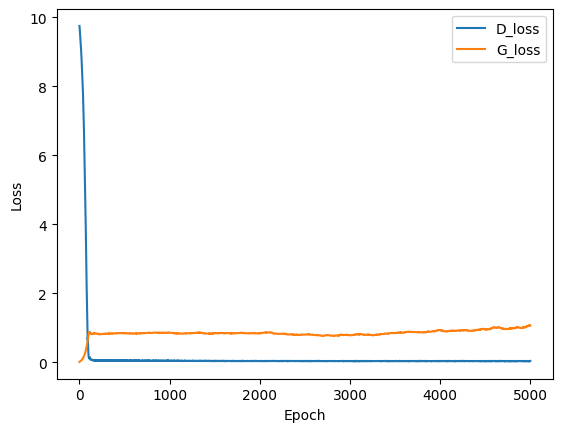

REAL (1746, 1)
[[-0.9801787 ]
 [-0.9812794 ]
 [-0.98266388]
 ...
 [-0.33843275]
 [-0.33313558]
 [-0.3303064 ]]
PREDICTED (1746, 1)
[[-0.9780409 ]
 [-0.9767544 ]
 [-0.9770024 ]
 ...
 [-0.3374065 ]
 [-0.33897242]
 [-0.3375901 ]]


<Figure size 640x480 with 0 Axes>

In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]
epoch = 5000

generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = Discriminator()
gan = GAN(generator, discriminator)
Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)

In [ ]:
import tensorflow as tf
generator = tf.keras.models.load_model('gen_GRU_model_retrain_v2.0_5000.h5')
generated_data = generator(X_test, training=False)
Predicted_price = generated_data
Real_price = y_test

In [ ]:
output_dim = y_test.shape[1]

In [ ]:
from pickle import load
from tensorflow.keras.losses import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd

----- predicted price ----- tf.Tensor(
[[-3.34938526e-01]
 [-3.30567777e-01]
 [-3.25535625e-01]
 [-3.19507986e-01]
 [-3.11797112e-01]
 [-3.05949152e-01]
 [-3.00453633e-01]
 [-2.96852946e-01]
 [-2.95866907e-01]
 [-2.93879062e-01]
 [-2.89270014e-01]
 [-2.82688349e-01]
 [-2.82027423e-01]
 [-2.86711633e-01]
 [-2.93714970e-01]
 [-2.95373708e-01]
 [-2.82542557e-01]
 [-2.70316303e-01]
 [-2.58500040e-01]
 [-2.55219668e-01]
 [-2.47780472e-01]
 [-2.40024060e-01]
 [-2.40970895e-01]
 [-2.44466409e-01]
 [-2.43808106e-01]
 [-2.34786287e-01]
 [-2.27268189e-01]
 [-2.29101270e-01]
 [-2.34848619e-01]
 [-2.41756767e-01]
 [-2.40638837e-01]
 [-2.37239420e-01]
 [-2.33232304e-01]
 [-2.32103735e-01]
 [-2.30538204e-01]
 [-2.26843655e-01]
 [-2.19162896e-01]
 [-2.12502196e-01]
 [-2.08059624e-01]
 [-2.09388971e-01]
 [-2.12029591e-01]
 [-2.16506273e-01]
 [-2.21758187e-01]
 [-2.23252028e-01]
 [-2.22411767e-01]
 [-2.23601058e-01]
 [-2.30139732e-01]
 [-2.33300418e-01]
 [-2.33693644e-01]
 [-2.33979791e-01]
 [-2.376744

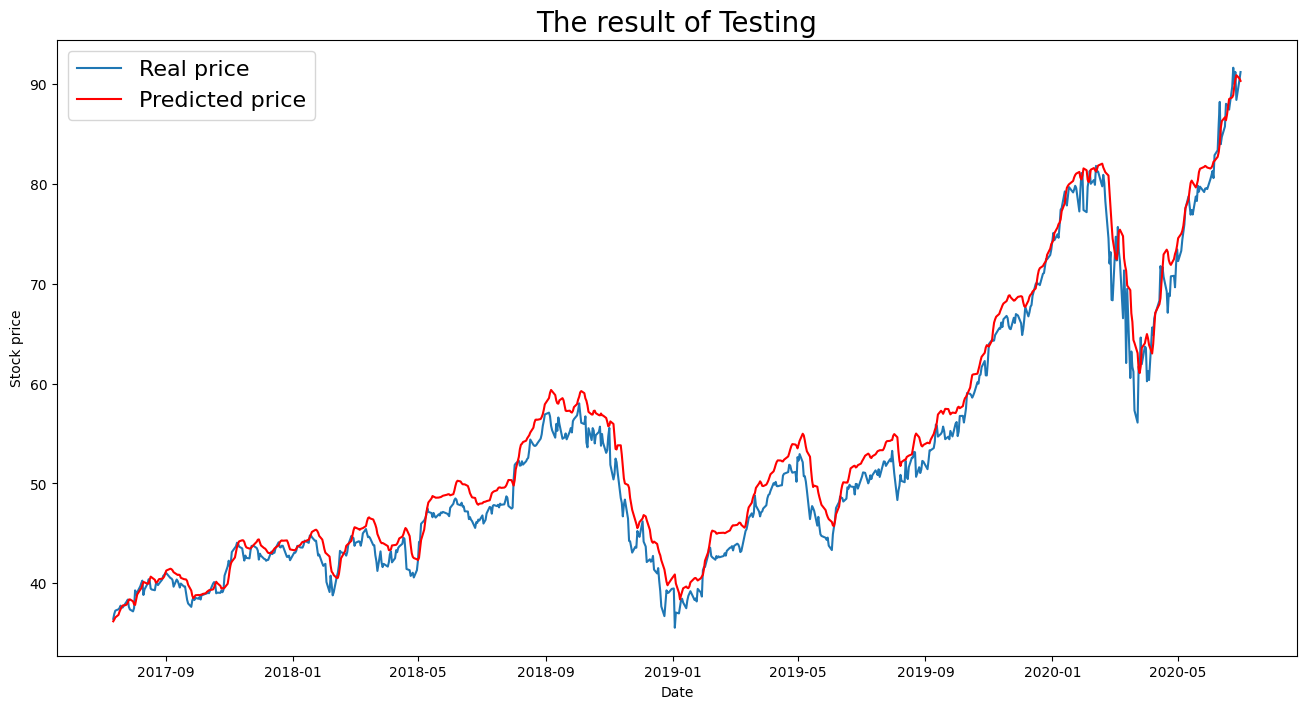

-- RMSE --  2.1260100833020332


<Figure size 640x480 with 0 Axes>

In [ ]:
# %% --------------------------------------- Plot the result -----------------------------------------------------

# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))

predict_index = np.load("index_test.npy", allow_pickle=True)

print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Testing", fontsize=20)
plt.show()
plt.savefig('train_plot.png')

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)

In [ ]:
predict_result.to_pickle("predict_result.pkl")  # where to save it, usually as a .pkl
real_price.to_pickle("real_price.pkl")  # where to save it, usually as a .pkl

In [ ]:
predict_result = pd.read_pickle("predict_result.pkl")
real_price = pd.read_pickle("real_price.pkl")

In [ ]:
preds = rescaled_Predicted_price.flatten()
real = rescaled_Real_price.flatten()
np.save("preds.npy", preds)
np.save("real.npy", real)

In [ ]:
# Load data
preds = np.load("preds.npy", allow_pickle=True)
real = np.load("real.npy", allow_pickle=True)

In [ ]:
# Load data
preds = np.array(predicted, dtype=np.float64)
real = np.array(real, dtype=np.float64)

We need to take the next day predictions of the model and take the certainties/ do some risk calculation and make stock bets based on that. This will give us our returns. Ideally we would want this to be significantly higher than just holding the stock.
Need to take our returns numbers and calculate the sharpe ratio for the holder and the day trader for a number of stocks.

In [ ]:
def evaluate_predictions(principal, prediction, real_amount):
  # principal (int): the initial amount invested
  # prediction (pd.Series): the predictions on each date
  # real (pd.Series): the actual values on each date
  daily_returns = []
  for i in range(len(prediction) - 1):
    initial_amount = principal
    num_shares = principal / real_amount[i]
    if prediction[i + 1] >= prediction[i]: # the stock will stay or go up in value
      principal += (num_shares * (real_amount[i + 1] - real_amount[i])) # increase by the increase in stock prince
    else:
      # the stock will go down
      principal += (num_shares * (real_amount[i] - real_amount[i + 1]))
    daily_returns.append((principal - initial_amount)/100)
  if len(daily_returns) > 0:
    daily_returns_mean = sum(daily_returns)/len(daily_returns)
  else:
    daily_returns_mean = 0.0
  std_dev = np.std(daily_returns)
  sharpe = (daily_returns_mean/std_dev) * (252 ** 0.5)
  return principal, sharpe

# print(evaluate_predictions(1000, predicted, real))

In [ ]:
preds_direction = np.empty(shape = (len(predict_result) - 1, 1),dtype = int)
for index in range(len(preds) - 1):
    preds_direction[index] = int((preds[index + 1] - preds[index]) > 0)

In [ ]:
best = 0
max = 0
for index in range(500):
  hold_profit = (real[index] / real[0]) * 1000.0
  predicted_profit, this_sharpe = evaluate_predictions(1000.0, preds[:index], real[:index])
  if best < (predicted_profit - hold_profit):
    best = (predicted_profit - hold_profit)
    max = index

/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
<ipython-input-23-1b6f83b033f2>:20: RuntimeWarning: divide by zero encountered in scalar divide
  sharpe = (daily_returns_mean/std_dev) * (252 ** 0.5)


In [ ]:
end = 364

print(evaluate_predictions(1000.0, preds[:end], real[:end]))
print((real[end] / real[0]) * 1000.0)
print(end)
print(predict_index[0])
print(predict_index[end])

(1225.623356187579, 0.5074545654102504)
1076.0943851764957
364
2017-07-12T00:00:00.000000000
2018-12-20T00:00:00.000000000


In [ ]:
print(predict_index[0])
print(predict_index[131])

2017-07-12T00:00:00.000000000
2018-01-18T00:00:00.000000000


In [ ]:
print(predict_index[0])
print(predict_index[end])

2017-07-12T00:00:00.000000000
2018-12-20T00:00:00.000000000


In [ ]:
print(preds[0])
print(preds[end])

print(real[0])
print(real[end])
print((real[end] / real[0]) * 1000.0)

36.19011947610402
42.79753242264261
36.435001
39.2075
1076.0943851764957


##XGBoost MODEL


In [ ]:
import xgboost as xgb

dataset = pd.read_csv('Finaldata_with_Fourier.csv', parse_dates = ['Date'])
y_train = dataset['Close'][:1001].values
X_train = dataset[['Google', 'Amazon', 'S&P 500', 'Microsoft']].loc[:1000]

y_test = dataset['Close'][1001:].values
X_test = dataset[['Google', 'Amazon', 'S&P 500', 'Microsoft']].loc[1001:]

clf = xgb.XGBRegressor(objective="reg:linear", max_depth = 3, n_estimators = 3000,  #The hyper-parameters were tuned using GridSearchCV
                       reg_alpha = 6.5, reg_lambda = 5, subsample = 0.8)

clf.fit(X_train, y_train)
train_score = clf.score(X_train, y_train)
test_score = clf.score(X_test, y_test)

print('Your training score is :{}\n Your testing score is :{}'.format(train_score, test_score))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:15:00] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


Your training score is :0.9918814662979208
 Your testing score is :-1.2821052470528658


In [ ]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 1} )
sess = tf.compat.v1.Session(config=config)
K.set_session(sess)

In [ ]:
K._get_available_gpus()

['/device:GPU:0']

In [ ]:
if __name__ == '__main__':
    if load_model == True:
        generator = tf.keras.models.load_model('gen_GRU_model_1000.h5')
        #generator.compile(optimizer="adam", loss="root_mean_squared_error")
        # generate fake output
        if train_mode == True:
            generated_data = generator(X_train, training=False)
            Predicted_price = generated_data
            Real_price = y_train
        else:
            generated_data = generator(X_test, training=False)
            Predicted_price = generated_data
            Real_price = y_test

    else:
        input_dim = X_train.shape[1]
        feature_size = X_train.shape[2]
        output_dim = y_train.shape[1]
        epoch = 5000

        generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
        discriminator = Discriminator()
        gan = GAN(generator, discriminator)
        Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)


In [ ]:
Predicted_price = []
Real_price = y_test
x = X_train
generator = tf.keras.models.load_model('gen_GRU_model_1000.h5')
for index in range(len(X_test)):
  x[:-1] = x[1:]
  x[-1] = X_test[index]
  generated_data = generator(X_train, training=False)
  Predicted_price.append(generated_data[-1])

In [ ]:
print(len(Predicted_price))
print(len(Real_price))

0
1496


In [ ]:
train_mode = False

----- predicted price ----- [<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.33360532], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3314364], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.32750973], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.32204148], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.31573412], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.311446], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3066809], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.30397627], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.3041545], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.30283874], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.2977826], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-0.29111665]

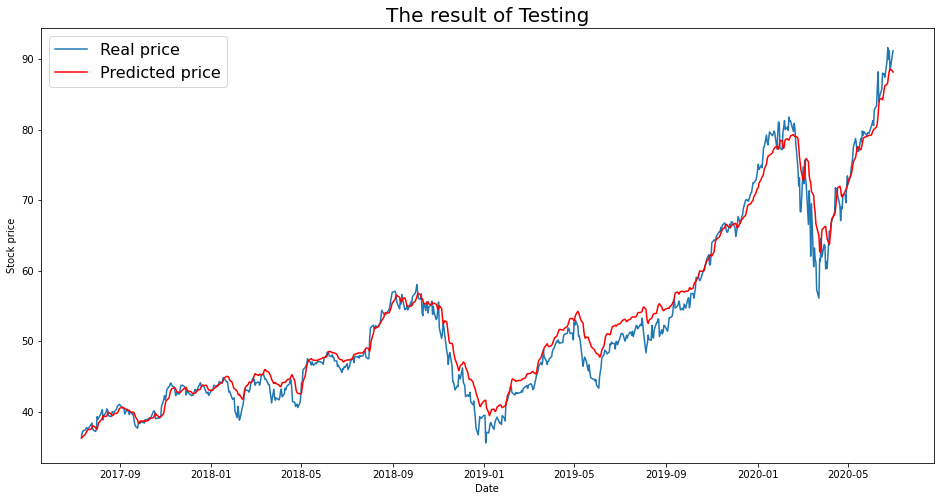

-- RMSE --  2.075060699175693


<Figure size 432x288 with 0 Axes>

In [ ]:
# %% --------------------------------------- Plot the result -----------------------------------------------------

# Rescale back the real dataset
X_scaler = load(open('X_scaler.pkl', 'rb'))
y_scaler = load(open('y_scaler.pkl', 'rb'))
if train_mode == True:
    predict_index = np.load("index_train.npy", allow_pickle=True)
else:
    predict_index = np.load("index_test.npy", allow_pickle=True)

print("----- predicted price -----", Predicted_price)

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

print("----- rescaled predicted price -----", rescaled_Predicted_price)
print("----- SHAPE rescaled predicted price -----", rescaled_Predicted_price.shape)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=predict_index[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=predict_index[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
if train_mode == True:
  plt.title("The result of Training", fontsize=20)
else:
  plt.title("The result of Testing", fontsize=20)
plt.show()
plt.savefig('train_plot.png')

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)

In [ ]:
predict_result.to_pickle("predict_result.pkl")  # where to save it, usually as a .pkl
real_price.to_pickle("real_price.pkl")  # where to save it, usually as a .pkl

In [ ]:
predict_result = pd.read_pickle("predict_result.pkl")
real_price = pd.read_pickle("real_price.pkl")

In [ ]:
preds = rescaled_Predicted_price.flatten()
real = rescaled_Real_price.flatten()
np.save("preds.npy", preds)
np.save("real.npy", real)

In [ ]:
# Load data
preds = np.load("preds.npy", allow_pickle=True)
real = np.load("real.npy", allow_pickle=True)

We need to take the next day predictions of the model and take the certainties/ do some risk calculation and make stock bets based on that. This will give us our returns. Ideally we would want this to be significantly higher than just holding the stock.

Need to take our returns numbers and calculate the sharpe ratio for the holder and the day trader for a number of stocks.

In [ ]:
def evaluate_predictions(principal, prediction, real_amount):
  # principal (int): the initial amount invested
  # prediction (pd.Series): the predictions on each date
  # real (pd.Series): the actual values on each date
  daily_returns = []
  for i in range(len(prediction) - 1):
    initial_amount = principal
    num_shares = principal / real_amount[i]
    if prediction[i + 1] >= prediction[i]: # the stock will stay or go up in value
      principal += (num_shares * (real_amount[i + 1] - real_amount[i])) # increase by the increase in stock prince
    else:
      # the stock will go down
      principal += (num_shares * (real_amount[i] - real_amount[i + 1]))
    daily_returns.append((principal - initial_amount)/100)
  daily_returns_mean = sum(daily_returns)/len(daily_returns)
  std_dev = np.std(daily_returns)
  sharpe = (daily_returns_mean/std_dev) * (252 ** 0.5)
  return principal, sharpe

# print(evaluate_predictions(1000, predicted, real))

In [ ]:
preds_direction = np.empty(shape = (len(predict_result) - 1, 1),dtype = int)
preds = rescaled_Predicted_price.flatten()
for index in range(len(preds) - 1):
    preds_direction[index] = int((preds[index + 1] - preds[index]) > 0)

In [ ]:
preds = rescaled_Predicted_price.flatten()
best = 0
max = 0
for index in range(150):
  hold_profit = (real[index] / real[0]) * 1000
  predicted_profit, this_sharpe = evaluate_predictions(1000, preds[:index], real[:index])
  if best < (predicted_profit - hold_profit):
    best = (predicted_profit - hold_profit)
    max = index
print(evaluate_predictions(1000, preds[:max], real[:max]))
print((real[max] / real[0]) * 1000)
print(max)
print(predict_index[0])
print(predict_index[max])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in double_scalars
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:263: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims, where=where)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  subok=False)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


(1181.1454711341205, 1.5198557959261685)
1064.5669530789912
146
2017-07-12T00:00:00.000000000
2018-02-08T00:00:00.000000000


In [ ]:
print(predict_index[0])
print(predict_index[131])

2017-07-12T00:00:00.000000000
2018-01-18T00:00:00.000000000


In [ ]:
print(real[0])
print(real[131])
print((real[131] / real[0]) * 1000)

36.435001
44.814999
1229.998566488306
